# Comparison to bulk RNA-seq data
One question we might have after sequencing an in vitro experiment is “How similar are our expression profiles compared to the public database?” To answer this, we generate “pseudobulks” by aggregating counts to the cell-type level and then compare them with bulk RNA-seq data.

In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import sys

sys.path.insert(1, str(Path().cwd().parent))
import common_config

In [2]:
common_config.figure_journal_basic()

In [3]:
import pertpy as pt
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
adata = sc.read_h5ad("data/mcfarland_preprocessed.h5ad")
adata

AnnData object with n_obs × n_vars = 154710 × 4000
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
cl_metadata = pt.md.CellLine()
cl_metadata.annotate(
    adata,
    query_id="DepMap_ID",
    reference_id="ModelID",
    fetch=["CellLineName", "Age", "OncotreePrimaryDisease", "SangerModelID"],
)

AnnData object with n_obs × n_vars = 154710 × 4000
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'CellLineName', 'Age', 'OncotreePrimaryDisease', 'SangerModelID'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
ps = pt.tl.PseudobulkSpace()
pdata = ps.compute(adata, target_col="CellLineName", groups_col="perturbation")

In [7]:
base_line = pdata[pdata.obs.perturbation == "control"]
base_line.obs.index = base_line.obs.index.str.replace("_control", "")

In [8]:
cl_metadata.annotate_bulk_rna(base_line, cell_line_source="broad", query_id="DepMap_ID")

❗ To annotate bulk RNA data from Broad Institue, `DepMap_ID` is used as default reference and query identifier if no `reference_id` is given.
Ensure that `DepMap_ID` is available in 'adata.obs'.
Alternatively, use `annotate()` to annotate the cell line first 
💡 There are 170 identifiers in `adata.obs`.However, 1 identifiers can't be found in the bulk RNA annotation,leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...


AnnData object with n_obs × n_vars = 170 × 4000
    obs: 'DepMap_ID', 'cancer', 'cell_line', 'disease', 'dose_unit', 'dose_value', 'organism', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'tissue_type', 'nperts', 'chembl-ID', 'CellLineName', 'Age', 'OncotreePrimaryDisease', 'SangerModelID', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'bulk_rna_broad'
    layers: 'psbulk_props'

In [9]:
base_line.obsm["bulk_rna_broad"]

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288714,ENSG00000288717,ENSG00000288718,ENSG00000288719,ENSG00000288720,ENSG00000288721,ENSG00000288722,ENSG00000288723,ENSG00000288724,ENSG00000288725
22Rv1,2.179511,0.0,6.316146,3.407353,4.642702,0.014355,0.124328,5.816088,7.045814,5.057017,...,0.000000,0.000000,0.000000,0.028569,0.250962,0.432959,3.875780,0.137504,0.0,0.000000
253J-BV,3.942045,0.0,5.967169,1.883621,3.581351,0.000000,0.084064,5.087463,4.444932,3.794936,...,0.000000,0.201634,0.124328,0.000000,0.150560,0.526069,4.526069,0.214125,0.0,0.000000
42-MG-BA,3.880686,0.0,6.733083,1.922198,3.390943,0.028569,0.575312,5.816856,3.313246,3.903038,...,0.028569,0.000000,0.042644,0.014355,0.070389,0.555816,2.601697,0.000000,0.0,0.084064
5637,5.128871,0.0,6.691534,2.010780,4.976364,0.163499,1.636915,6.193575,3.505891,3.709291,...,0.000000,0.000000,0.150560,0.028569,0.014355,0.298658,2.978196,0.000000,0.0,0.000000
639-V,4.328406,0.0,7.058749,1.891419,3.529821,0.000000,3.878725,6.432792,4.698774,4.912650,...,0.028569,0.201634,0.028569,0.056584,0.189034,0.505891,3.820690,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TUHR4TKB,4.309613,0.0,7.265849,2.042644,3.553361,0.097611,5.257765,6.048105,4.058316,3.539779,...,0.000000,0.000000,0.000000,0.000000,0.014355,0.411426,4.647315,0.000000,0.0,0.000000
UACC-257,4.134221,0.0,6.318498,2.042644,4.228049,0.042644,0.176323,5.866908,4.586164,4.361066,...,0.000000,0.000000,0.286881,0.028569,0.111031,0.632268,5.216843,0.000000,0.0,0.000000
UM-UC-1,5.683416,0.0,7.125155,1.963474,2.523562,0.028569,2.969012,5.472488,4.869378,3.543496,...,0.000000,0.000000,0.000000,0.189034,0.000000,0.731183,2.587365,0.000000,0.0,0.000000
WM-266-4,4.161888,0.0,6.267349,2.572890,3.729009,0.163499,0.903038,6.166715,4.543496,3.340562,...,0.000000,0.000000,0.000000,0.000000,0.214125,0.321928,4.305241,0.000000,0.0,0.000000


In [10]:
overlapping_genes = set(base_line.var.ensembl_id) & set(
    base_line.obsm["bulk_rna_broad"].columns
)
base_line = base_line[:, base_line.var["ensembl_id"].isin(overlapping_genes)]
base_line.obsm["bulk_rna_broad"] = base_line.obsm["bulk_rna_broad"][
    base_line.var.ensembl_id
]

In [11]:
# Log normalize the counts
sc.pp.log1p(base_line)
# Correlate the pseudobulks with the bulk RNA-seq data
# corr and pvals: correlation and p-value df for the overlapping cell lines
# unmatched_cl_orr and unmatched_cl_pvals: correlation and p-value df for cell lines that are only present in McFarland dataset
corr, pvals, unmatched_cl_corr, unmatched_cl_pvals = cl_metadata.correlate(
    base_line, identifier="DepMap_ID", metadata_key="bulk_rna_broad"
)

❗ Column name of metadata is not the same as the index of adata.var. Ensure that the genes are in the same order.


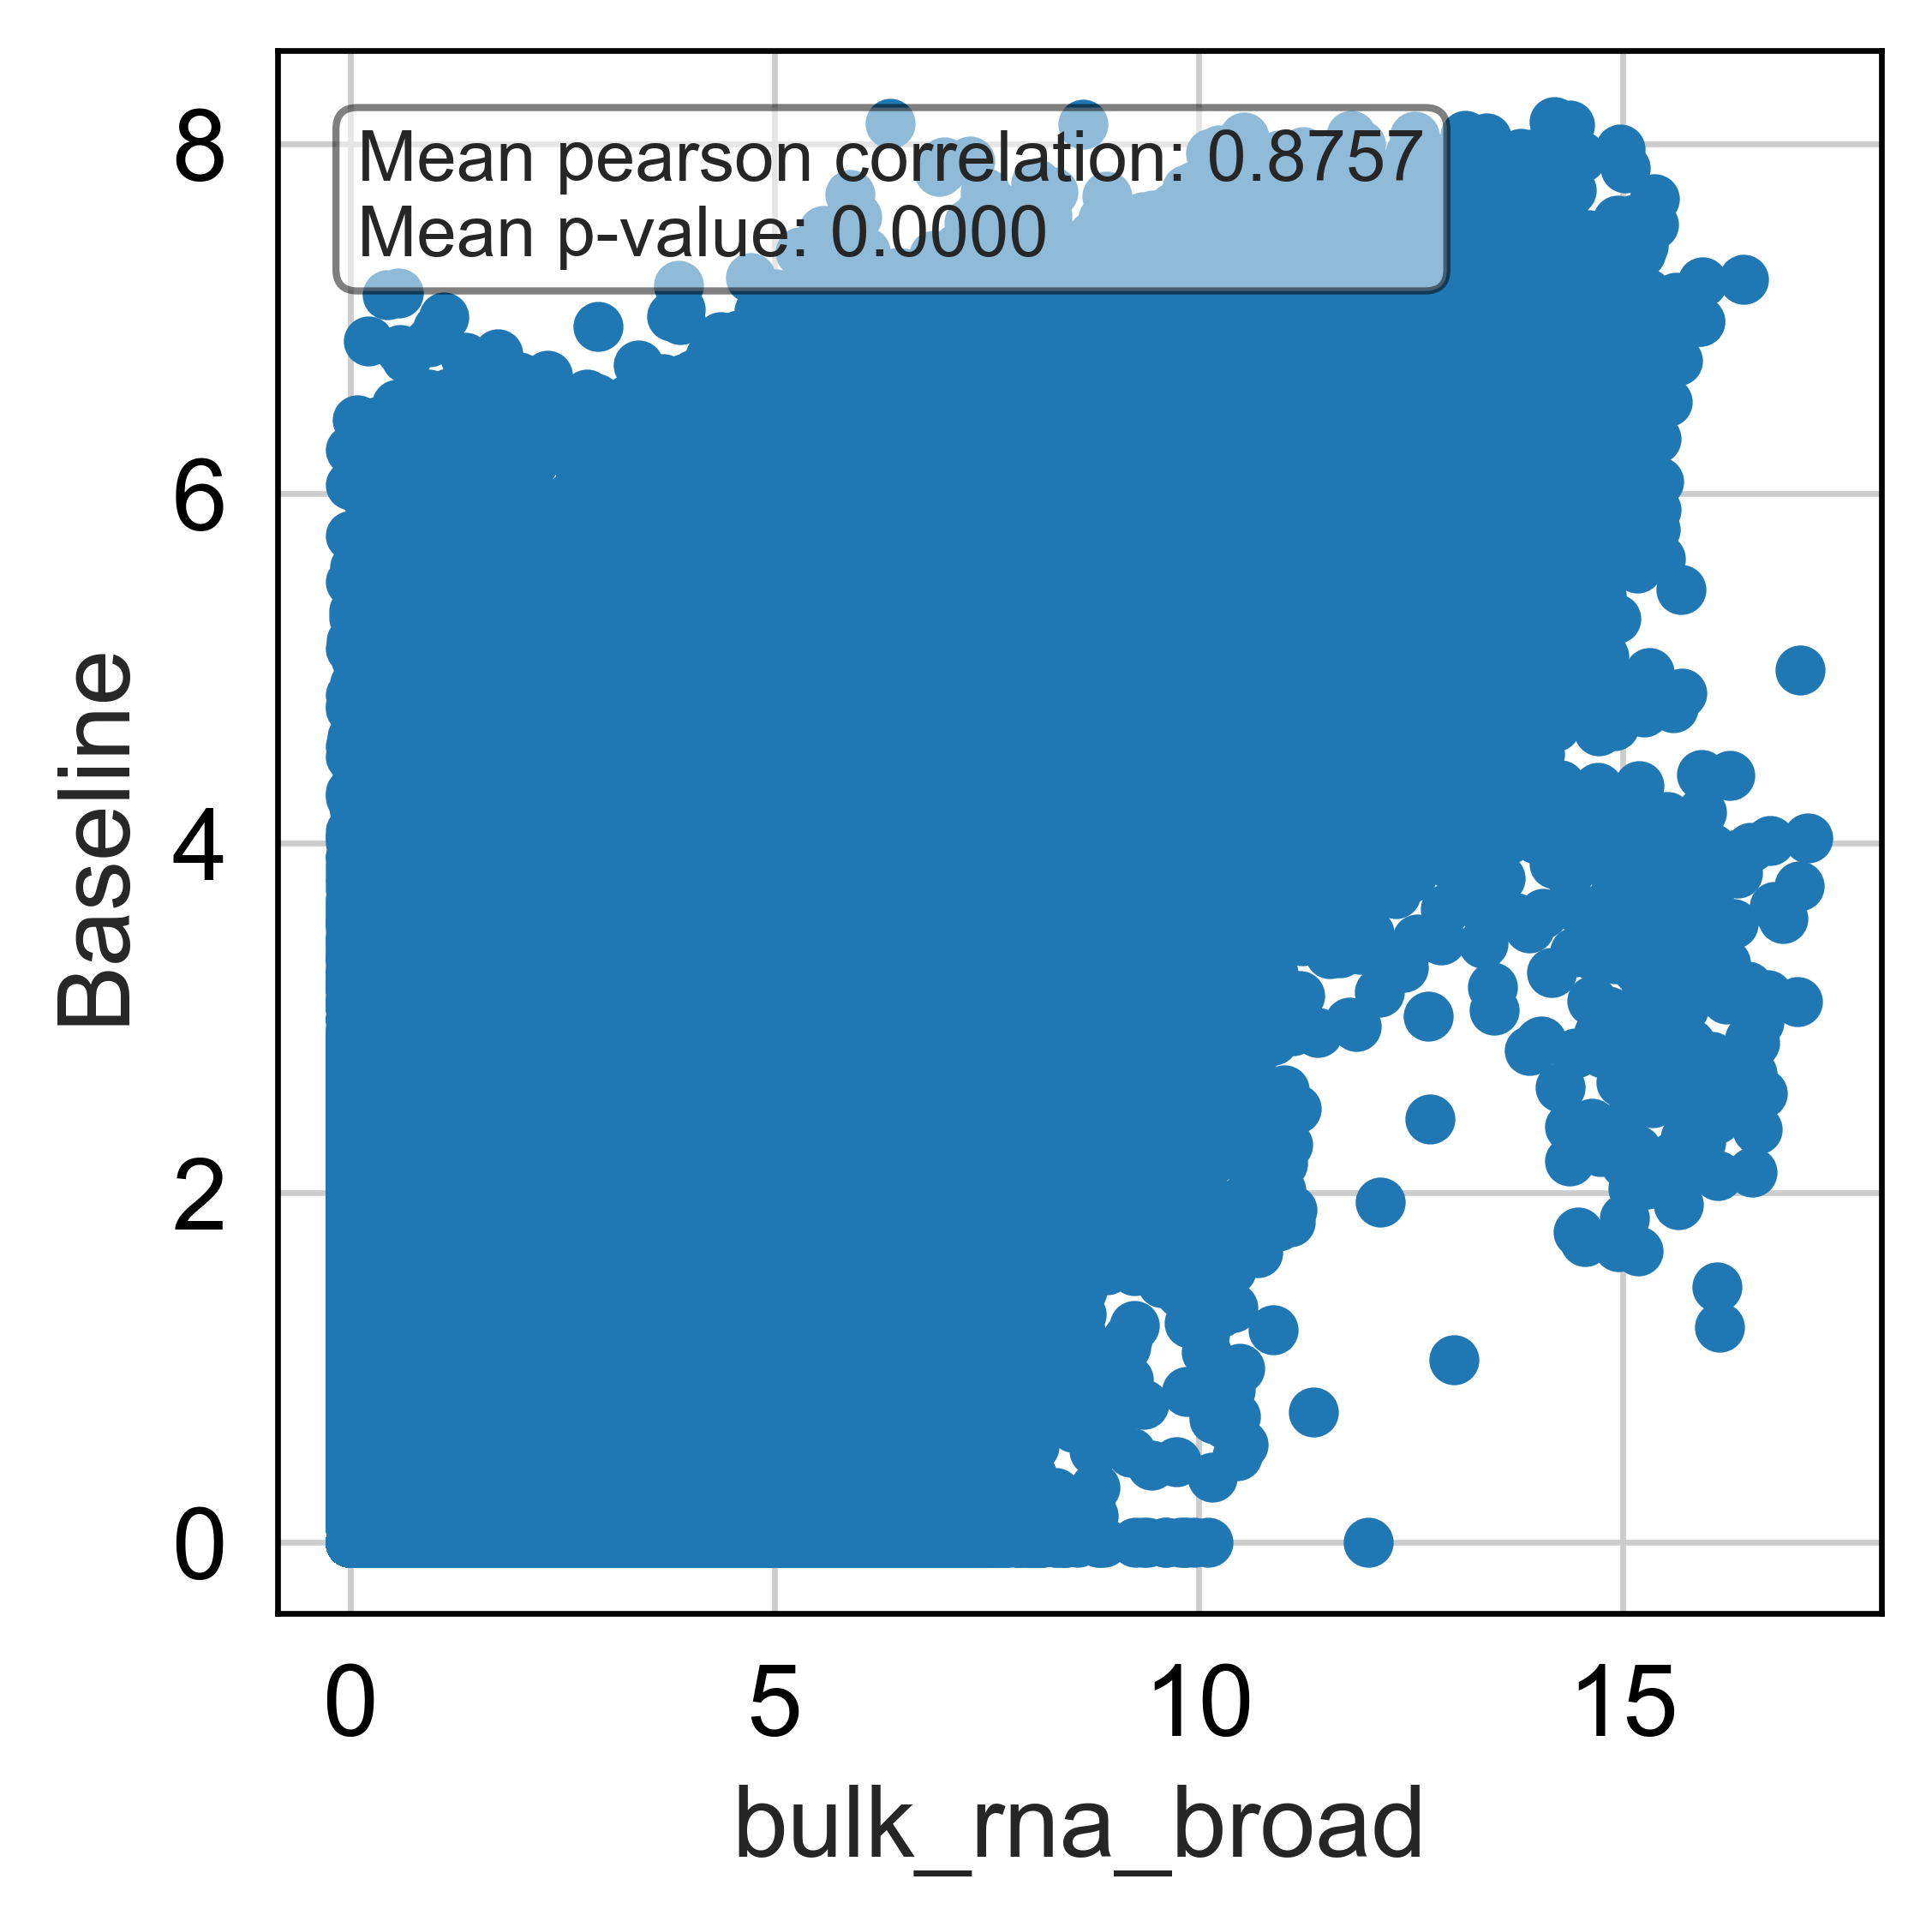

<Figure size 1200x1200 with 0 Axes>

In [12]:
# Visualize the correlation of cell lines by scatter plot
cl_metadata.plot_correlation(
    base_line,
    corr=corr,
    pval=pvals,
    identifier="DepMap_ID",
    metadata_key="bulk_rna_broad",
    subset_identifier=None,
)
plt.savefig("figures/mcfarland_bulk_comparison.png", dpi=300)

Mean pearson correlation: 0.8757
Mean p-value: 0.0000


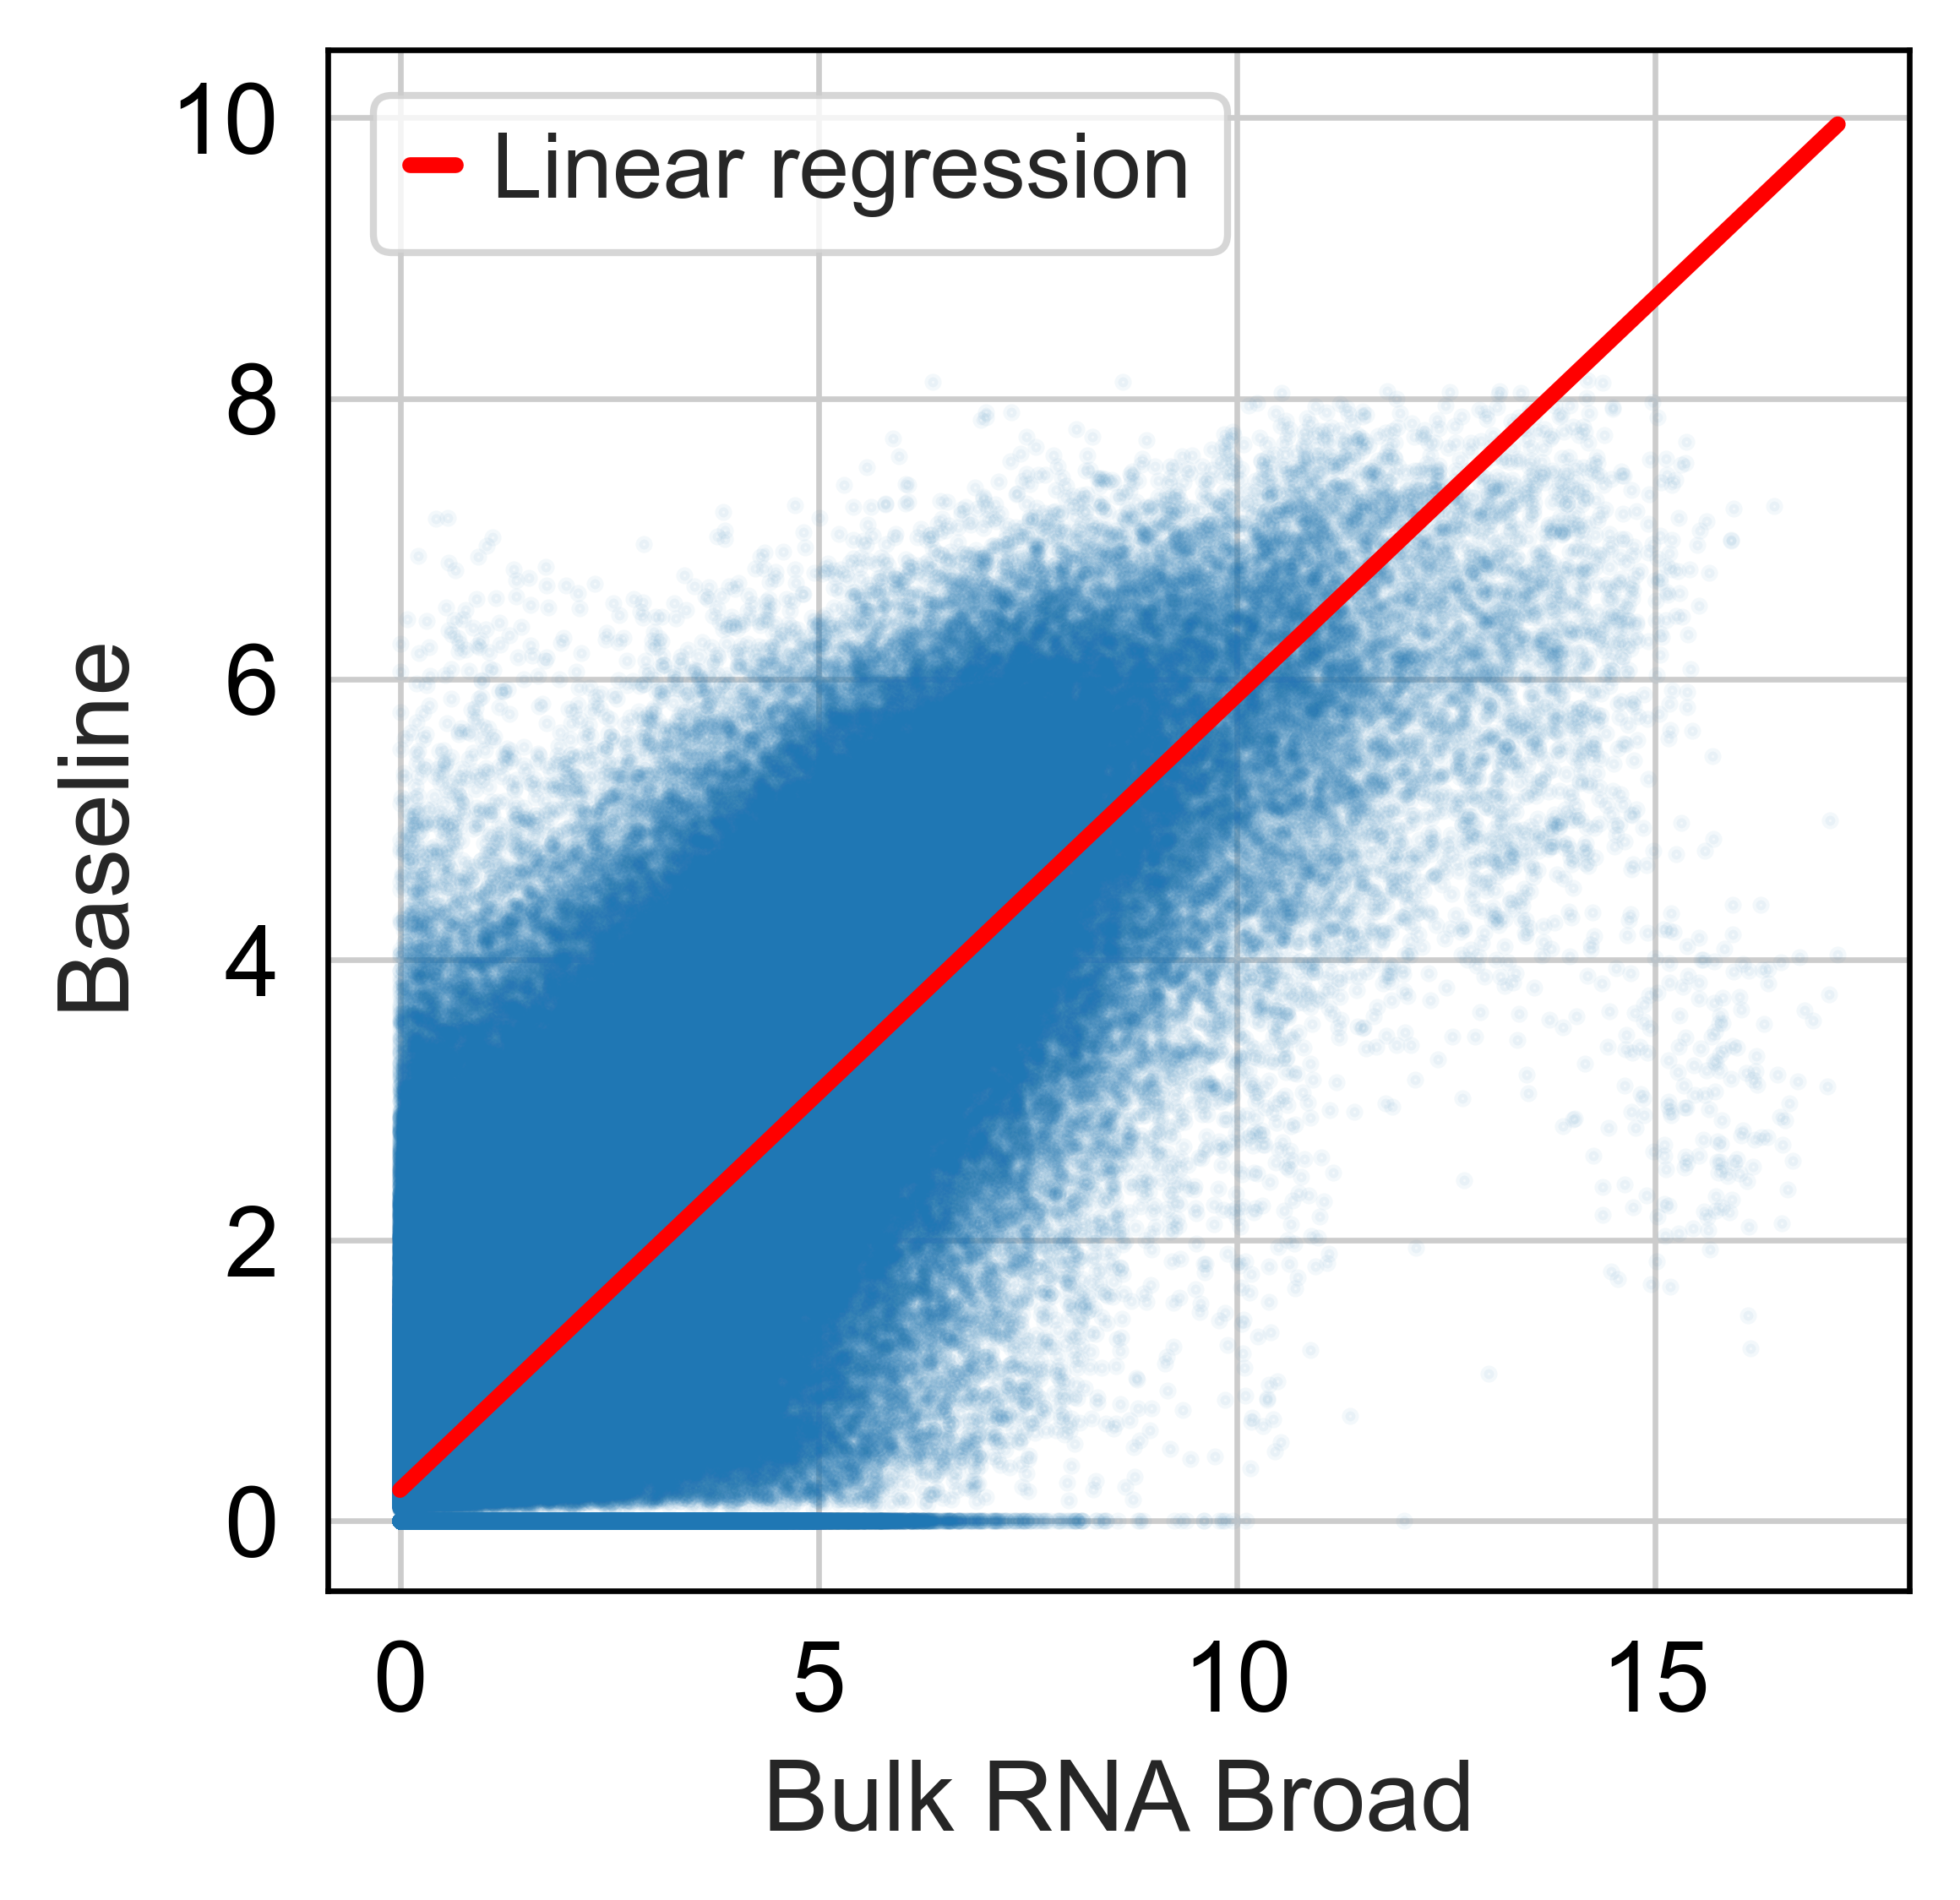

In [13]:
annotation = "\n".join(
    (
        f"Mean pearson correlation: {np.mean(np.diag(corr)):.4f}",
        f"Mean p-value: {np.mean(np.diag(pvals)):.4f}",
    )
)
print(annotation)

plot_df = pd.DataFrame(
    {
        "Bulk RNA Broad": base_line.obsm["bulk_rna_broad"].to_numpy().flatten(),
        "Baseline": base_line.X.flatten(),
    }
)

sns.regplot(
    x="Bulk RNA Broad",
    y="Baseline",
    data=plot_df,
    ci=99,
    scatter_kws={"s": 2, "alpha": 0.05},
    line_kws={"color": "red", "label": "Linear regression"},
)

plt.legend()

plt.savefig("figures/mcfarland_bulk_comparison_all_cell_lines.png", dpi=300)

In [28]:
annotation = "\n".join(
    (
        f"Mean pearson correlation: {np.mean(np.diag(corr)):.4f}",
        f"Mean p-value: {np.mean(np.diag(pvals)):.4f}",
    )
)
print(annotation)

x = base_line.obsm["bulk_rna_broad"].to_numpy().flatten()
y = base_line.X.flatten()

nan_mask = ~np.isnan(x) & ~np.isnan(y)
x = x[nan_mask]
y = y[nan_mask]

hist, xedges, yedges = np.histogram2d(x, y, bins=100)
hist_log = np.log1p(hist.T)
xidx = np.searchsorted(xedges, x, side="right") - 2 #TODO: -1 or -2?
yidx = np.searchsorted(yedges, y, side="right") - 2
density_log = hist_log[xidx, yidx]


print("Density calculated!")

plot_df = pd.DataFrame(
    {
        "Bulk RNA Broad": x,
        "Baseline": y,
        "Log Density": density_log,
    }
)

plot_df = plot_df.sort_values("Log Density", ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(5.2,5), gridspec_kw={'width_ratios': [20, 1]})

sns.scatterplot(x="Bulk RNA Broad",
                y="Baseline", 
                hue='Log Density', 
                palette='rocket',
                s=2,
                alpha=0.5,
                data=plot_df,
                rasterized=True,
                ax=axes[0],
)

norm = plt.Normalize(plot_df['Log Density'].min(), plot_df['Log Density'].max())
sm = plt.cm.ScalarMappable(cmap="rocket", norm=norm)
sm.set_array([])
axes[0].get_legend().remove()
plt.colorbar(sm, cax=axes[1], label='Log Density')

sns.regplot(
    x="Bulk RNA Broad",
    y="Baseline",
    data=plot_df,
    ci=99,
    scatter=False,
    line_kws={"color": "red", "label": "Linear regression"},
    ax=axes[0],
)

plt.savefig("figures/mcfarland_bulk_comparison_all_cell_lines.pdf", dpi=300, bbox_inches='tight')

Mean pearson correlation: 0.8757
Mean p-value: 0.0000
Density calculated!
